# **Project Structure**
 1. Data Preprocessing
 2. Model Implementation
 3. Training and Evaluation
 4. Parameter Analysis
 5. Result Visualization

# Data Preprocessing

In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import emoji
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Load datasets
tec_df = pd.read_csv('https://archive.org/download/misc-dataset/TEC.csv')
semeval_df = pd.read_csv('https://archive.org/download/misc-dataset/semeval2018-task1-emoc.csv')
goemotions_df = pd.read_csv('https://archive.org/download/misc-dataset/goemotions_full.csv')

# Rename label columns to a common name 'label' for TEC dataset
tec_df.rename(columns={'emotion': 'label'}, inplace=True)

# Convert multi-label columns to a single multi-class label for SEMEVAL dataset
semeval_df['label'] = semeval_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].idxmax(axis=1)

# Convert multi-label columns to a single multi-class label for GoEmotions dataset
goemotions_df['label'] = goemotions_df[['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']].idxmax(axis=1)

# Function to convert emoticons to emojis
def convert_emoticons_to_emojis(text):
    return emoji.emojize(text)

# Apply the function to your text data
tec_df['text'] = tec_df['text'].apply(convert_emoticons_to_emojis)
semeval_df['text'] = semeval_df['text'].apply(convert_emoticons_to_emojis)
goemotions_df['text'] = goemotions_df['text'].apply(convert_emoticons_to_emojis)

# Combine datasets
combined_df = pd.concat([tec_df[['text', 'label']], semeval_df[['text', 'label']], goemotions_df[['text', 'label']]])

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_df['text'])
sequences = tokenizer.texts_to_sequences(combined_df['text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, combined_df['label'], test_size=0.2, random_state=42)

# Randomly select 6000 samples from the training set
train_sample = 6000
X_train_sampled, y_train_sampled = X_train[:train_sample], y_train[:train_sample]

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(combined_df['label'])  # Fit on the entire dataset to ensure consistency
y_train_encoded = to_categorical(label_encoder.transform(y_train_sampled))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Verify number of classes
num_classes = len(label_encoder.classes_)
print(f'Number of classes: {num_classes}')


Number of classes: 31


# Model Implementation

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU, SimpleRNN, Flatten

# Function to create models
def create_model(model_type, input_dim=5000, output_dim=128, input_length=100, num_classes=num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    if model_type == 'LSTM':
        model.add(LSTM(100, dropout=0.5))
    elif model_type == 'CNN':
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Flatten())  # Add Flatten to ensure correct output shape
    elif model_type == 'GRU':
        model.add(GRU(256, dropout=0.5))
    elif model_type == 'CNN-LSTM':
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(LSTM(100, dropout=0.5))
    elif model_type == 'GRU-LSTM':
        model.add(GRU(256, return_sequences=True, dropout=0.5))
        model.add(LSTM(100, dropout=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# Training Evaluation

In [ ]:
# Train and evaluate models
model_types = ['LSTM', 'CNN', 'GRU', 'CNN-LSTM', 'GRU-LSTM']
histories = {}
for model_type in model_types:
    # Fit label encoder on the training data to get the correct number of classes
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_sampled)
    y_train_encoded = to_categorical(y_train_encoded)

    # Transform the test labels using the same encoder
    y_test_encoded = label_encoder.transform(y_test)
    y_test_encoded = to_categorical(y_test_encoded)

    # Get the number of classes for the model
    num_classes = len(label_encoder.classes_)

    model = create_model(model_type, num_classes=num_classes) # Pass the correct number of classes to the model
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    histories[model_type] = history
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    print(f'{model_type} Model - Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
300/300 [==============================] - 39s 121ms/step - loss: 2.9626 - accuracy: 0.2175 - val_loss: 2.8602 - val_accuracy: 0.2433
Epoch 2/10
300/300 [==============================] - 24s 81ms/step - loss: 2.8229 - accuracy: 0.2396 - val_loss: 2.7340 - val_accuracy: 0.2742
Epoch 3/10
300/300 [==============================] - 23s 77ms/step - loss: 2.4451 - accuracy: 0.3385 - val_loss: 2.6487 - val_accuracy: 0.3033
Epoch 4/10
300/300 [==============================] - 21s 69ms/step - loss: 2.0476 - accuracy: 0.4331 - val_loss: 2.6831 - val_accuracy: 0.2883
Epoch 5/10
300/300 [==============================] - 22s 75ms/step - loss: 1.7243 - accuracy: 0.5133 - val_loss: 2.7871 - val_accuracy: 0.2883
Epoch 6/10
300/300 [==============================] - 23s 76ms/step - loss: 1.4286 - accuracy: 0.5998 - val_loss: 3.0119 - val_accuracy: 0.2808
Epoch 7/10
300/300 [==============================] - 23s 75ms/step - loss: 1.1990 - accuracy: 0.6621 - val_loss: 3.1179 - val_accuracy

# Parameter Analysis

In [ ]:
# Create GRU-LSTM model variants
def create_gru_lstm_model(activation='tanh', loss='categorical_crossentropy', optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
    model.add(GRU(256, return_sequences=True, dropout=0.5))
    model.add(LSTM(100, dropout=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

# Train and evaluate GRU-LSTM variants
activations = ['relu', 'sigmoid']
losses = ['mean_squared_error']
optimizers = ['sgd', 'rmsprop']
gru_lstm_histories = {}

for activation in activations:
    model = create_gru_lstm_model(activation=activation)
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    gru_lstm_histories[f'Activation {activation}'] = history
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    print(f'GRU-LSTM Model with {activation} Activation - Loss: {loss}, Accuracy: {accuracy}')

for loss in losses:
    model = create_gru_lstm_model(loss=loss)
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    gru_lstm_histories[f'Loss {loss}'] = history
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    print(f'GRU-LSTM Model with {loss} Loss - Loss: {loss}, Accuracy: {accuracy}')

for optimizer in optimizers:
    model = create_gru_lstm_model(optimizer=optimizer)
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    gru_lstm_histories[f'Optimizer {optimizer}'] = history
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    print(f'GRU-LSTM Model with {optimizer} Optimizer - Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/10
300/300 [==============================] - 99s 317ms/step - loss: 2.9599 - accuracy: 0.2169 - val_loss: 2.8494 - val_accuracy: 0.2433
Epoch 2/10
300/300 [==============================] - 100s 335ms/step - loss: 2.7379 - accuracy: 0.2681 - val_loss: 2.6694 - val_accuracy: 0.3050
Epoch 3/10
300/300 [==============================] - 96s 319ms/step - loss: 2.4205 - accuracy: 0.3377 - val_loss: 2.6677 - val_accuracy: 0.2875
Epoch 4/10
300/300 [==============================] - 94s 314ms/step - loss: 2.1151 - accuracy: 0.4150 - val_loss: 2.6852 - val_accuracy: 0.2900
Epoch 5/10
300/300 [==============================] - 99s 331ms/step - loss: 1.8292 - accuracy: 0.4860 - val_loss: 2.8198 - val_accuracy: 0.2817
Epoch 6/10
300/300 [==============================] - 94s 315ms/step - loss: 1.6117 - accuracy: 0.5510 - val_loss: 2.9492 - val_accuracy: 0.2658
Epoch 7/10
300/300 [==============================] - 99s 331ms/step - loss: 1.3726 - accuracy: 0.6065 - val_loss: 3.2352 - val_a

# Result Visualisation

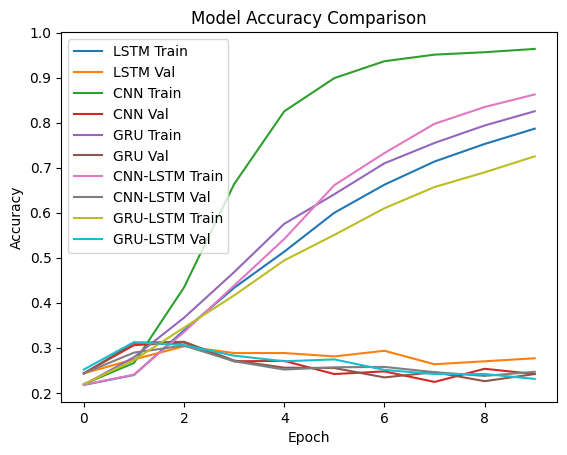

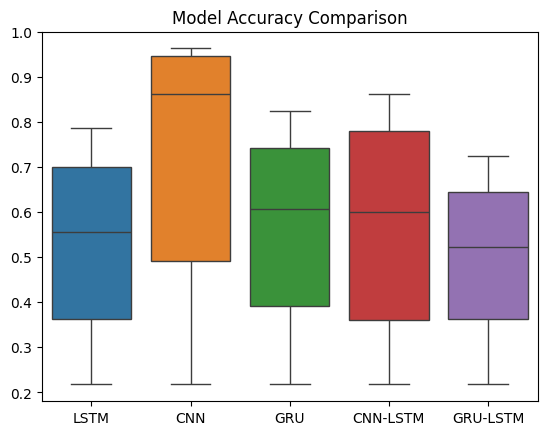

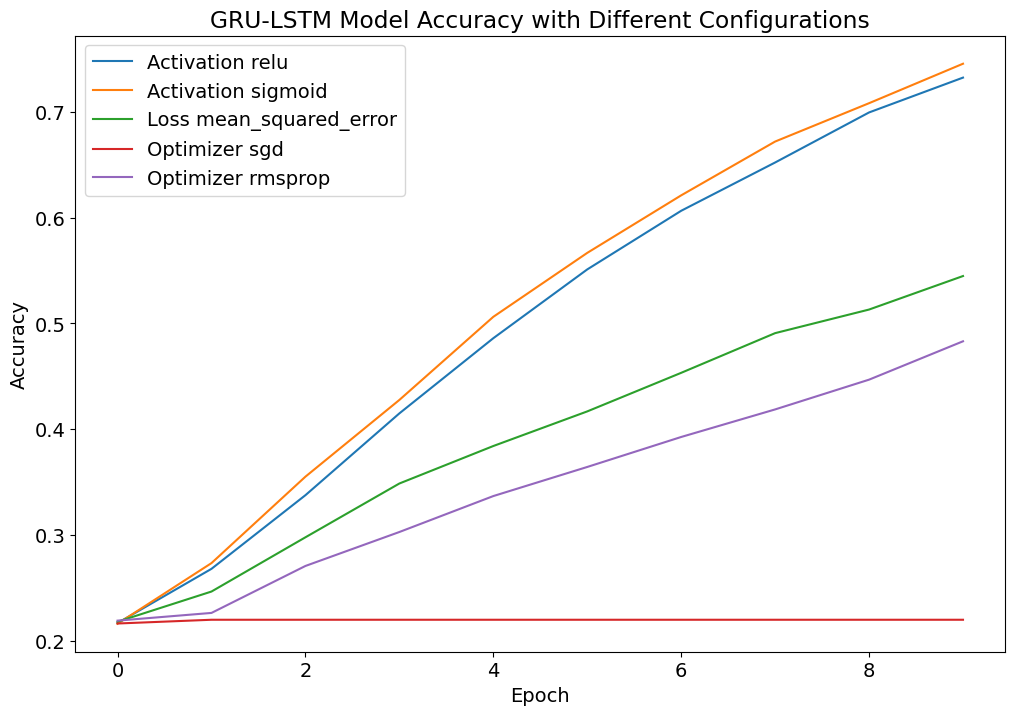

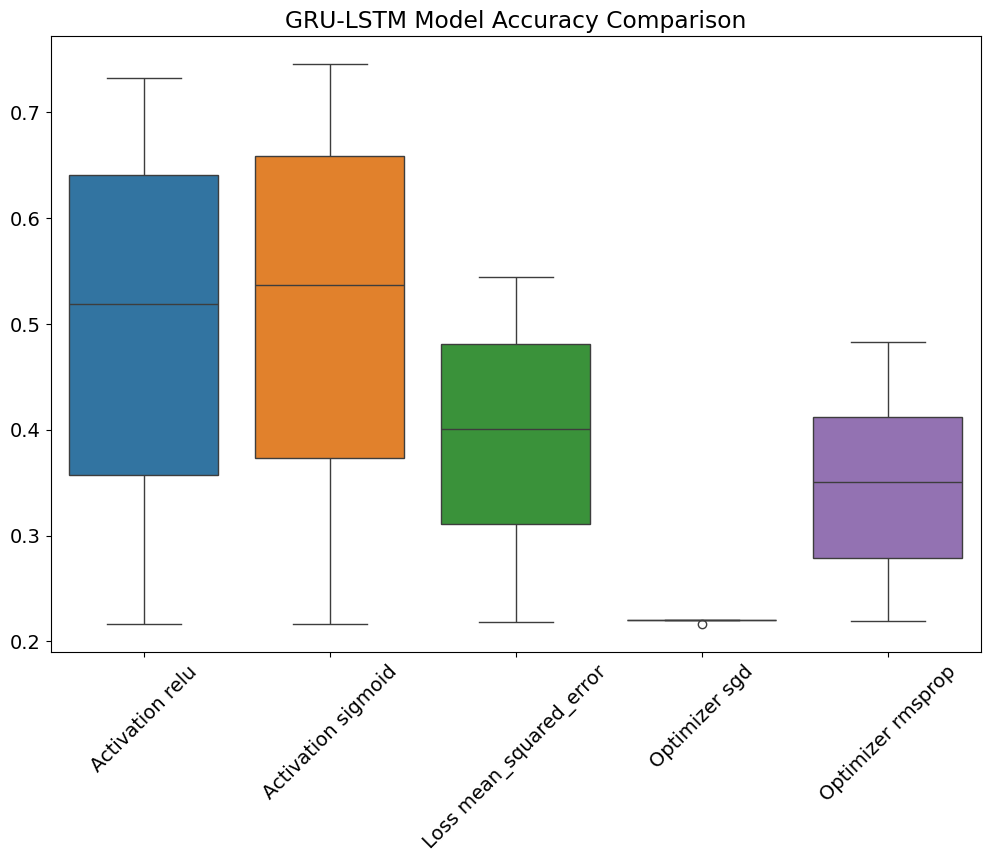

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot accuracy for different models
for model_type, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_type} Train')
    plt.plot(history.history['val_accuracy'], label=f'{model_type} Val')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Boxplot for model accuracy
results = {model_type: history.history['accuracy'] for model_type, history in histories.items()}
sns.boxplot(data=pd.DataFrame(results))
plt.title('Model Accuracy Comparison')
plt.show()

# Increase the font size for better readability
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})

# Plot GRU-LSTM model accuracies with different configurations
for config, history in gru_lstm_histories.items():
    plt.plot(history.history['accuracy'], label=config)
plt.title('GRU-LSTM Model Accuracy with Different Configurations')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Boxplot for GRU-LSTM model accuracy comparisons with increased font size
results = {config: history.history['accuracy'] for config, history in gru_lstm_histories.items()}
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame(results))
plt.title('GRU-LSTM Model Accuracy Comparison')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, LSTM, Dense
from keras.optimizers import SGD, RMSprop

# Your existing code here
# Create GRU-LSTM model variants
def create_gru_lstm_model(activation='tanh', loss='categorical_crossentropy', optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
    model.add(GRU(256, return_sequences=True, dropout=0.5))
    model.add(LSTM(100, dropout=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

# Train and evaluate GRU-LSTM variants
activations = ['relu', 'sigmoid']
losses = ['mean_squared_error']
optimizers = ['sgd', 'rmsprop']

# Dictionaries to store results
gru_lstm_histories = {}
results = {}
overall_metrics = {}

for activation in activations:
    model = create_gru_lstm_model(activation=activation)
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    gru_lstm_histories[f'Activation {activation}'] = history.history['accuracy']
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    overall_metrics[f'GRU-LSTM {activation}'] = {'loss': loss, 'accuracy': accuracy}
    results[f'GRU-LSTM {activation}'] = history.history['accuracy']
    print(f'GRU-LSTM Model with {activation} Activation - Loss: {loss}, Accuracy: {accuracy}')

for loss in losses:
    model = create_gru_lstm_model(loss=loss)
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    gru_lstm_histories[f'Loss {loss}'] = history.history['accuracy']
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    overall_metrics[f'GRU-LSTM {loss}'] = {'loss': loss, 'accuracy': accuracy}
    results[f'GRU-LSTM {loss}'] = history.history['accuracy']
    print(f'GRU-LSTM Model with {loss} Loss - Loss: {loss}, Accuracy: {accuracy}')

for optimizer in optimizers:
    model = create_gru_lstm_model(optimizer=optimizer)
    history = model.fit(X_train_sampled, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)
    gru_lstm_histories[f'Optimizer {optimizer}'] = history.history['accuracy']
    loss, accuracy = model.evaluate(X_test, y_test_encoded)
    overall_metrics[f'GRU-LSTM {optimizer}'] = {'loss': loss, 'accuracy': accuracy}
    results[f'GRU-LSTM {optimizer}'] = history.history['accuracy']
    print(f'GRU-LSTM Model with {optimizer} Optimizer - Loss: {loss}, Accuracy: {accuracy}')

# Print results
print("Results: ", results)
print("Overall Metrics: ", overall_metrics)

# Calculate min, max, average, and std deviation for each configuration
import numpy as np

metrics_table = {}

for config, accuracies in results.items():
    metrics_table[config] = {
        'Min': np.min(accuracies),
        'Max': np.max(accuracies),
        'Ave': np.mean(accuracies),
        'Std': np.std(accuracies),
        'Overall Loss': overall_metrics[config]['loss'],
        'Overall Accuracy': overall_metrics[config]['accuracy']
    }

# Convert to a structured table (e.g., Pandas DataFrame)
import pandas as pd

metrics_df = pd.DataFrame(metrics_table).T
print(metrics_df)


NameError: name 'num_classes' is not defined